## svmsoft

From A First Course in Machine Learning, Chapter 5.


Simon Rogers, 01/11/21 [simon.d.rogers@gmail.com]

Soft-margin SVM

*Note*: this code requires the package `quadprog`. Can be installed with

```
pip install quadprog
```


In [4]:
import numpy as np
import pylab as plt
%matplotlib inline

Generate some data

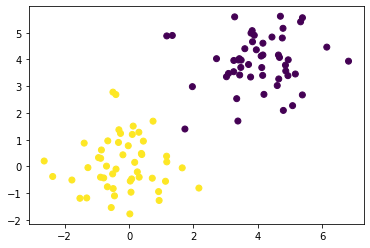

In [5]:
np.random.seed(125)
n = 50
X1 = np.random.multivariate_normal(
    [0, 0],
    np.eye(2),
    size=n
)
X2 = np.random.multivariate_normal(
    [4, 4],
    np.eye(2),
    size=n
)
t1 = np.ones((n, 1), int)
t2 = -1*np.ones((n, 1), int) # note we use +- 1 for SVM

X = np.vstack((X1, X2))
t = np.vstack((t1, t2))

# to really see the hard margin, we flip point 41
# (if not flipped it it the closest yellow point to the purple class)
t[41] = -t[41]


plt.scatter(X[:, 0], X[:, 1], c=t)

Very basic SVM class. Uses quadprog for the quadratic programming. Note that quadprog minimises and we maximise.

This is changed very slightly from the version in svmhard.ipynb
- There is now a `C` parameter in the class
- $\alpha$ values are constrained to be less than or equal to `C` (note quadprog only takes constraints of the form $\geq$ so we encode these constraints as $-\alpha \geq -C$)
- Computing b is slightly different (see bottom of p.192 in 2nd edition of book)

In [28]:
import quadprog

class LinearKernel(object):
    def compute_gram(self, X1, X2=None):
        if X2 is None:
            return np.dot(X1, X1.T)
        else:
            return np.dot(X1, X2.T)

# The only change from the hard margin is the addition of C, and the additional
# constraints that the alpha values must be less than or equal C
# encoded as -alp >= -C rather than alp <= C for compatibility with quadprog
class LinearSVM(object):
    def __init__(self, X, t, C=1e6, kernel=LinearKernel()):
        self.X = X
        self.t = t
        self.kernel = kernel
        self.C = C
        self.K = self.kernel.compute_gram(X)
        self.N, _ = self.X.shape
    
    def train(self):
        a = np.ones(self.N) # multiplier for linear term
        tt = np.dot(self.t, self.t.T)
        G = (self.K * tt) + 1e-10*np.eye(self.N) # quadratic term (1e-10 for numerical stability)
        C = np.hstack((self.t, np.eye(self.N), -1*np.eye(self.N))) # constraints (equality and then inequality)
        b = np.hstack((np.zeros(1), np.zeros(self.N), -self.C*np.ones(self.N))) # constraints
        self.alp, _, _, _, _, _ = quadprog.solve_qp(G, a, C, b, meq=1)
        
        # compute b
        self.compute_b()
        return self # allows instantiations and train in one command
    
    def compute_b(self):
        # find the SV with the highest value of sum_m alpha_m t_m K(x_m, x_n)
        temp = (self.alp*self.t.flatten()*self.K).sum(axis=0)
        sv_pos = np.argmax(temp)
        self.b = self.t[sv_pos] - (self.alp*self.t.flatten()*self.K[sv_pos, :]).sum()
        
    def classify(self, testX):
        '''
        Compute raw classification (real) value
        '''
        testK = self.kernel.compute_gram(self.X, testX)
        temp = (self.alp*self.t.flatten())[:, None]*testK
        temp = temp.sum(axis=0) + self.b
        return temp

    def classify_labels(self, testX):
        '''
        Compute predicted label
        '''
        temp = self.classify(testX)
        temp = 1*(temp > 0)
        temp = 2 * temp - 1
        return temp
    
    def get_svs(self, thresh=1e-5):
        '''
        Get the SVs
        '''
        pos = np.where(self.alp >= thresh)[0]
        return self.X[pos,:]
    
    def __str__(self):
        return f'Linear SVM, C = {self.C}'

Plot the contour at 0 at the solution. Note that non SV alphas are not exactly zero. Here we threshold at 1e-5.

In [29]:
def plot_contours(X, t, classifier, MIN_X=-2,
                  MAX_X=6, MIN_Y=-2, MAX_Y=5,
                  n_x=50, n_y=60, levels=[0.5]):
    
    xv = np.linspace(MIN_X, MAX_X, n_x)
    yv = np.linspace(MIN_Y, MAX_Y, n_y)
    
    Xg, Yg = np.meshgrid(xv, yv)
    
    gridX = np.hstack((
        Xg.ravel()[:, None],
        Yg.ravel()[:, None]
    ))
    
    preds = classifier.classify(gridX)

    Z = np.reshape(preds, (n_y, n_x))

    fig, ax = plt.subplots(figsize=(10, 10))
    ax.scatter(X[:, 0], X[:, 1], c=t)
    CS = ax.contour(Xg, Yg, Z, levels=levels, colors='k')
    ax.clabel(CS, CS.levels, inline=True, fontsize=10)
    ax.set_title(str(classifier))
    return ax


Plot the contours for three values of C:
- 0.1: strong regularisation, reducing the impact of outliers
- 1.0: still fairly strong
- 10.0: effectively no regularisaion, same solution as hard margin case

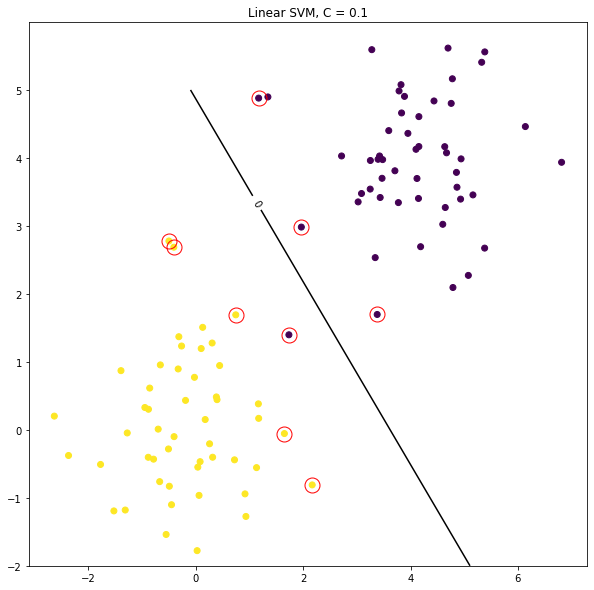

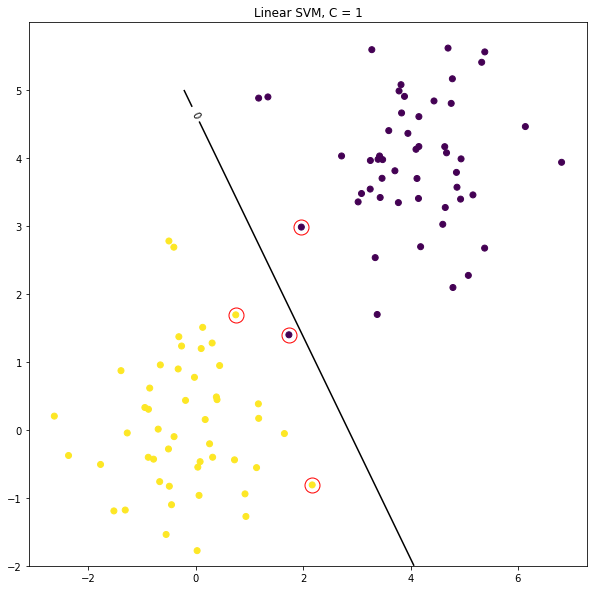

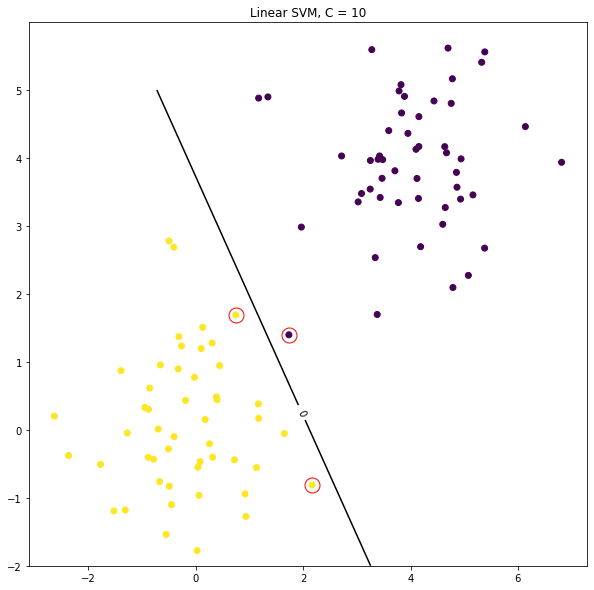

In [30]:
for C in [0.1, 1, 10]:
    svm = LinearSVM(X, t, C=C).train()
    ax = plot_contours(X, t, svm, levels=[0.0])
    svs = svm.get_svs(thresh=1e-5)
    ax.plot(svs[:,0], svs[:, 1], 'ro', markersize=15, markerfacecolor='none')